In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest

In [27]:
'''
date
date of publication of the announcement

price
Price. in rubles

level
Apartment floor

levels
Number of storeys

rooms
the number of living rooms. If the value is "-1", then it means "studio apartment"

area
the total area of the apartment

kitchen_area
Kitchen area

geo_lat
Latitude

geo_lon
Longitude

building_type
Facade type. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

object_type
Apartment type. 0 - Secondary real estate market; 2 - New building

postal_code
Postal code

street_id
Street ID

id_region
Region of Russia. There are 85 subjects in the country in total

house_id
House ID

'''

'\ndate\ndate of publication of the announcement\n\nprice\nPrice. in rubles\n\nlevel\nApartment floor\n\nlevels\nNumber of storeys\n\nrooms\nthe number of living rooms. If the value is "-1", then it means "studio apartment"\n\narea\nthe total area of the apartment\n\nkitchen_area\nKitchen area\n\ngeo_lat\nLatitude\n\ngeo_lon\nLongitude\n\nbuilding_type\nFacade type. 0 - Don\'t know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden\n\nobject_type\nApartment type. 0 - Secondary real estate market; 2 - New building\n\npostal_code\nPostal code\n\nstreet_id\nStreet ID\n\nid_region\nRegion of Russia. There are 85 subjects in the country in total\n\nhouse_id\nHouse ID\n\n'

In [80]:
apart_params = pd.read_csv('apart_prices.csv', sep = ';', dtype={
    'level': 'int32',
    'levels': 'int32',
    'rooms': 'int16',
    'id_region': 'int32'},
    usecols = ['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'id_region'])
apart_params.head(10000)

,date,price,level,levels,rooms,area,kitchen_area,id_region
0,2021-01-01,2451300,15,31,1,30.3,0.0,66
1,2021-01-01,1450000,5,5,1,33.0,6.0,1
2,2021-01-01,10700000,4,13,3,85.0,12.0,50
3,2021-01-01,3100000,3,5,3,82.0,9.0,1
4,2021-01-01,2500000,2,3,1,30.0,9.0,23
...,...,...,...,...,...,...,...,...
9995,2021-01-02,6180000,9,10,4,96.0,9.4,63
9996,2021-01-02,14548000,22,26,2,61.0,13.6,77
9997,2021-01-02,2950000,9,9,1,30.0,0.0,72
9998,2021-01-02,2522470,6,20,1,39.5,0.0,24


In [30]:
# Delete extra ads of the same apartment
apart_params = apart_params.drop_duplicates(['level', 'levels', 'rooms', 'area', 'kitchen_area', 'id_region'], keep = 'last')
# Assign NaN to the wrong kitchen area
apart_params.loc[apart_params['kitchen_area'] <= 0.0, 'kitchen_area'] = np.NaN
# Delete rows with the wrong id_region and with the wrong price
apart_params = apart_params.drop(apart_params[(apart_params.id_region == 200) | (apart_params.price <= 0.0)].index)
# Create a new column about m2 price
apart_params['m2_price'] = np.int64(apart_params['price'] / apart_params['area'])
median_m2_prices = apart_params.groupby('id_region', as_index = False).agg({'m2_price': 'median'}).sort_values(by='m2_price', ascending=False).head(20)
mean_m2_prices = apart_params.groupby('id_region', as_index = False).agg({'m2_price': 'mean'}).sort_values(by='m2_price', ascending=False).head(20)
#apart_params.tail(100)

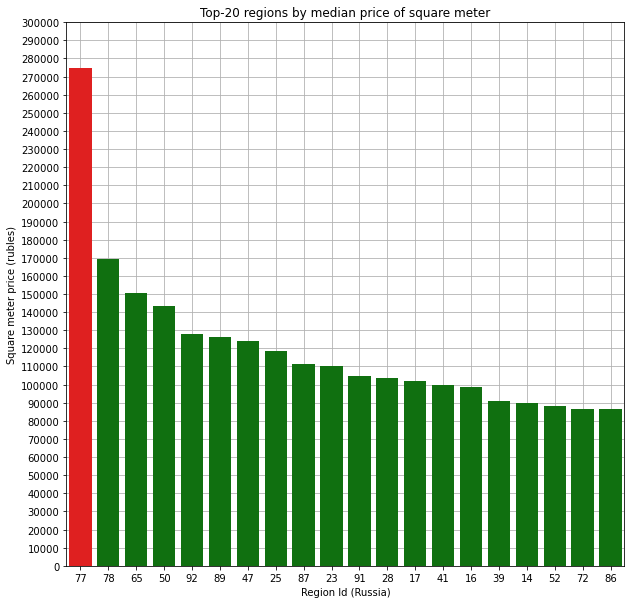

In [31]:
# Top-20 regions by median price of square meter
f, ax = plt.subplots(figsize=(10, 10))
cols = ['red' if (median_m2_price == max(median_m2_prices.m2_price)) else 'green' for median_m2_price in median_m2_prices.m2_price]
sns.barplot(data=median_m2_prices, x='id_region', y='m2_price', ax=ax, palette = cols, 
            order=median_m2_prices.sort_values('m2_price', ascending=False).id_region)
ax.set_ylim(0, 300_000)
ax.set_yticks(range(0, 310_000, 10_000))
ax.set_title('Top-20 regions by median price of square meter')
ax.set_xlabel("Region Id (Russia)")
ax.set_ylabel("Square meter price (rubles)")
ax.grid(True)
ax.set_axisbelow(True)

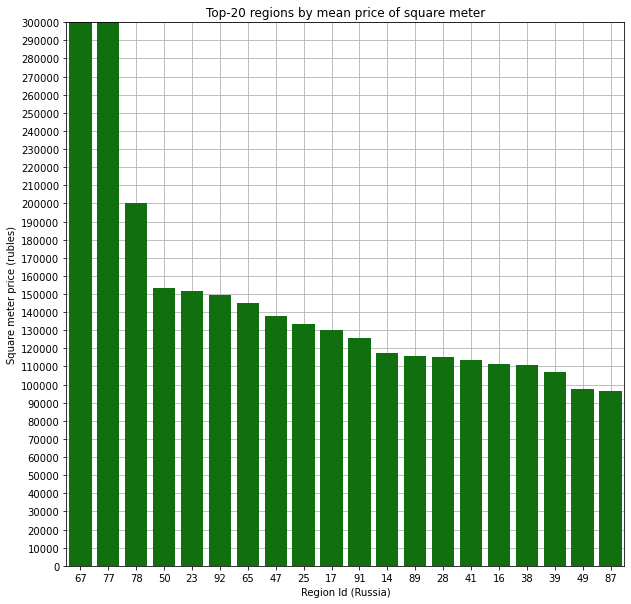

In [32]:
# Top-20 regions by mean price of square meter
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=mean_m2_prices, x='id_region', y='m2_price', ax=ax, color = 'g', 
            order=mean_m2_prices.sort_values('m2_price', ascending=False).id_region)
ax.set_ylim(0, 300_000)
ax.set_yticks(range(0, 310_000, 10_000))
ax.set_title('Top-20 regions by mean price of square meter')
ax.set_xlabel("Region Id (Russia)")
ax.set_ylabel("Square meter price (rubles)")
ax.grid(True)
ax.set_axisbelow(True)

(100000, 100000000)

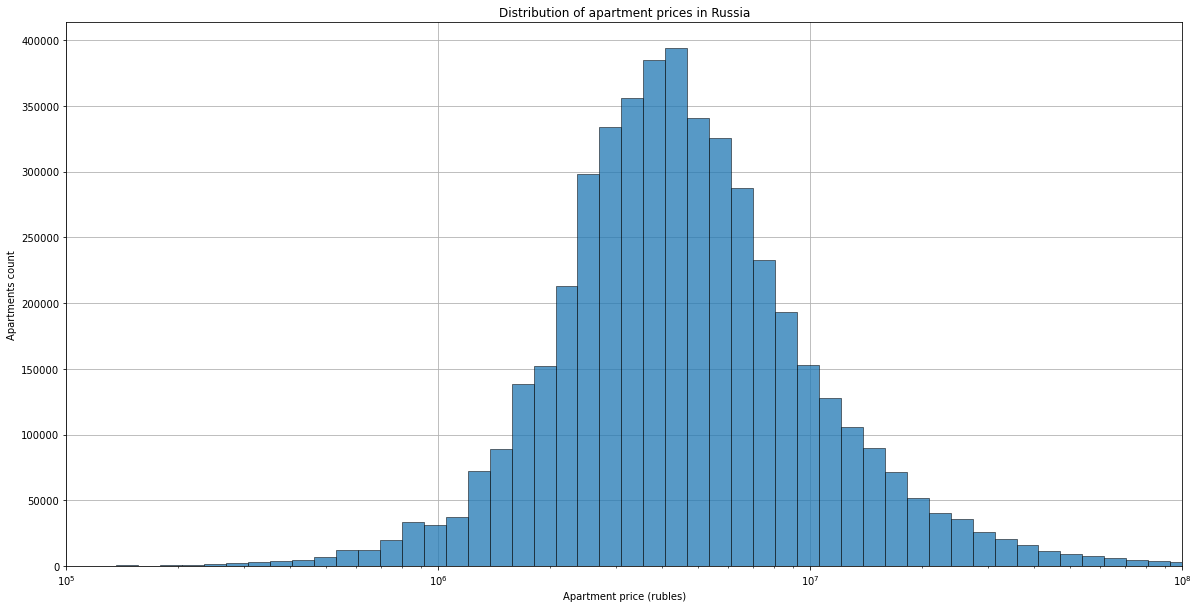

In [33]:
# Distribution of apartment prices in Russia
f, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data = apart_params, x = 'price', log_scale=True, bins = 200)
ax.set_title('Distribution of apartment prices in Russia')
ax.set_xlabel("Apartment price (rubles)")
ax.set_ylabel("Apartments count")
ax.grid(True)
ax.set_axisbelow(True)
ax.set_xlim(100_000, 100_000_000)


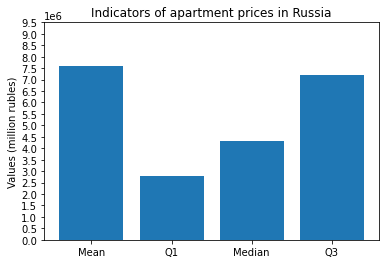

In [34]:
# Statistics metrics about apartment prices in Russia
mean_apart_params = apart_params['price'].mean()
quantiles = stat.quantiles(apart_params['price'])

# Indicators of apartment prices in Russia
labels = np.array(['Mean', 'Q1', 'Median', 'Q3'])
values = np.array([mean_apart_params, quantiles[0], quantiles[1], quantiles[2]])
plt.bar(labels, values)
plt.ylabel('Values (million rubles)')
plt.title('Indicators of apartment prices in Russia')
plt.yticks(np.arange(0, 10_000_000, 500_000))
plt.show()



In [35]:
# Find percent difference between mean and median prices
print(f'Mean price is {np.round_((mean_apart_params - quantiles[1]) / quantiles[1] * 100, 2)}% higher than median price')
print('''It means that extremely expensive apartments have high impact on mean price in contrast to cheap apartments
It could be a sign of outliers in the expensive zone
Median shows real prices much better than mean because of asymmetric distribution''')

Mean price is 75.31% higher than median price
It means that extremely expensive apartments have high impact on mean price in contrast to cheap apartments
It could be a sign of outliers in the expensive zone
Median shows real prices much better than mean because of asymmetric distribution


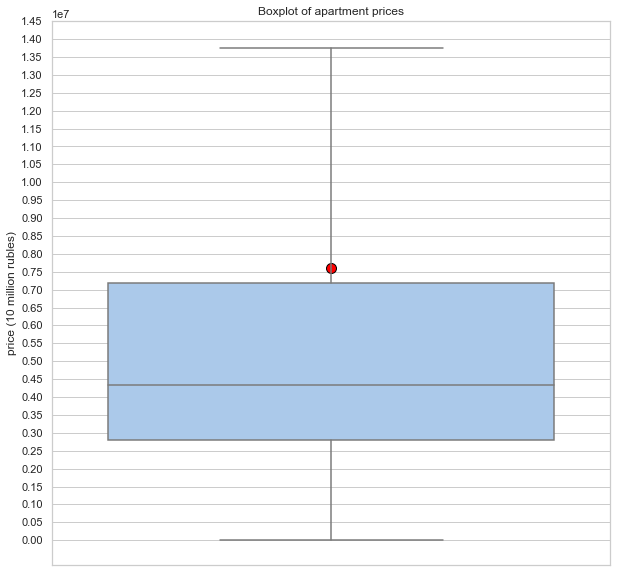

In [36]:
# Boxplot of apartment prices 
fig = plt.figure(figsize = (10, 10))
sns.set_theme(style="whitegrid")
sns.set_palette(palette="pastel")
sns.boxplot(y = apart_params['price'], showfliers = False)
plt.scatter(0, mean_apart_params, marker='o', s=100, color = 'red', edgecolors = 'black', label = 'Среднее')
plt.ylabel('price (10 million rubles)')
plt.title('Boxplot of apartment prices')
plt.yticks(np.arange(0, 15_000_000, 500_000))
plt.show()

In [22]:
# Сheck the distribution of prices for normality using Shapiro-Wilk test
prices_distribution = apart_params['price']
shapiro(prices_distribution)


ShapiroResult(statistic=0.0018529295921325684, pvalue=0.0)

In [ ]:
# We see the fact that p-value < 0.05 => we have the reason to don't consider this distribution normal

In [24]:
# Сheck the distribution of prices for normality using Kolmogorov–Smirnov test
kstest(prices_distribution, 'norm')

KstestResult(statistic=0.9992857991825661, pvalue=0.0)

In [ ]:
# We see the fact that p-value < 0.05 => we have the reason to don't consider this distribution normal

In [49]:
# Check the correlation between price and area
apart_params['price'].apply(np.log).corr(apart_params['area'])

0.5466523738780664

In [ ]:
# We see the fact that correlation with the log scale shows the fairly strong relationship between price and area in Russia

In [58]:
# Check the correlation between price and area in Moscow
apart_params.loc[apart_params['id_region'] == 77, 'price'].corr(apart_params.loc[apart_params['id_region'] == 77, 'area'])

0.5018636698201135

In [ ]:
# We see the fact that correlation without the log scale shows the fairly strong relationship between price and area in Moscow

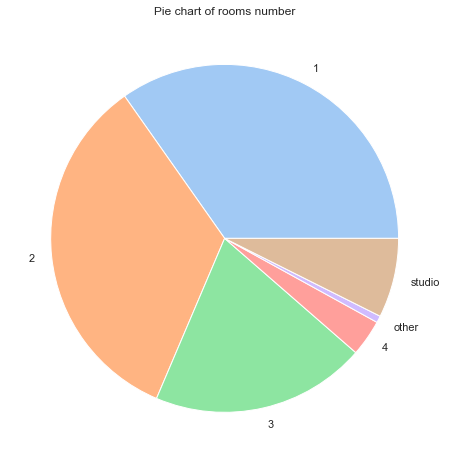

In [98]:
# Pie chart of rooms number
rooms_distribution = apart_params[['rooms']]
# Try to get clear categories - other (> 5 rooms) and studio (apart with no bedroom)
rooms_distribution.loc[rooms_distribution['rooms'] >= 5, 'rooms'] = 'other'
rooms_distribution.loc[rooms_distribution['rooms'] == -1, 'rooms'] = 'studio'
rooms = rooms_distribution.groupby('rooms').size()

rooms.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Pie chart of rooms number")
plt.ylabel("")
plt.show()